In [52]:
pip install ucimlrepo

In [53]:
from sklearn.datasets import load_digits
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import count
import pandas as pd

In [54]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "adult.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "wenruliu/adult-income-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

Using Colab cache for faster access to the 'adult-income-dataset' dataset.
First 5 records:    age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own

In [55]:
y = df[['income']].copy()
X = df.drop('income', axis=1)
X_categorical = X.select_dtypes(include=['object'])

# Extract the names of those features
categorical_feature_names = X_categorical.columns.tolist()

print(f"Names of categorical features identified by type: {categorical_feature_names}")
print("\nFirst 5 records of Categorical Features:")
X_categorical.head()

Names of categorical features identified by type: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

First 5 records of Categorical Features:


,workclass,education,marital-status,occupation,relationship,race,gender,native-country
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States
4,?,Some-college,Never-married,?,Own-child,White,Female,United-States


removing NaN values and replacing them with 'Unkown'

In [56]:
X_categorical = X_categorical.replace('?', np.nan)

print("Missing values before 'Unknown' imputation:")
print(X_categorical.isnull().sum())
# Impute all NaN values with the string 'Unknown'
X_categorical_imputed = X_categorical.fillna('Unknown')

print("\nMissing values after 'Unknown' imputation:")
print(X_categorical_imputed.isnull().sum())

Missing values before 'Unknown' imputation:
workclass         2799
education            0
marital-status       0
occupation        2809
relationship         0
race                 0
gender               0
native-country     857
dtype: int64

Missing values after 'Unknown' imputation:
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
gender            0
native-country    0
dtype: int64


We perform [ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). The features are converted to ordinal integers.

This results in a single column of integers (0 to n_categories - 1) per feature.

In [57]:
# Initialize the encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# Note: handle_unknown='use_encoded_value' is generally good practice
# but may not strictly be needed since you already imputed 'Unknown'.

# Fit the encoder to your data (this learns the unique categories in each column)
encoder.fit(X_categorical_imputed)

# Transform the data (this converts the strings to integers)
X_categroial_integer_encoded_array = encoder.transform(X_categorical_imputed)

# Convert the resulting NumPy array back to a Pandas DataFrame for easy analysis
X_categroial_integer_encoded = pd.DataFrame(
    X_categroial_integer_encoded_array,
    columns=X_categorical_imputed.columns,
    index=X_categorical_imputed.index
)
X_categroial_integer_encoded.head()

,workclass,education,marital-status,occupation,relationship,race,gender,native-country
0,3.0,1.0,4.0,6.0,3.0,2.0,1.0,38.0
1,3.0,11.0,2.0,4.0,0.0,4.0,1.0,38.0
2,1.0,7.0,2.0,10.0,0.0,4.0,1.0,38.0
3,3.0,15.0,2.0,6.0,0.0,2.0,1.0,38.0
4,7.0,15.0,4.0,14.0,3.0,4.0,0.0,38.0


splitting into train test validation

In [58]:
x_train, x_temp, y_train, y_temp = train_test_split(X_categroial_integer_encoded, y['income'], train_size=0.70, random_state=42, stratify=y['income'])
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size=0.50, random_state=42, stratify=y_temp)

print(f"Training set shape:   {x_train.shape} | {y_train.shape}")
print(f"Validation set shape: {x_val.shape} | {y_val.shape}")
print(f"Test set shape:       {x_test.shape} | {y_test .shape}")

Training set shape:   (34189, 8) | (34189,)
Validation set shape: (7326, 8) | (7326,)
Test set shape:       (7327, 8) | (7327,)


/tmp/ipython-input-1094343902.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_train_counts.index, y=y_train_counts.values, palette='viridis')


Text(0, 0.5, 'Count')

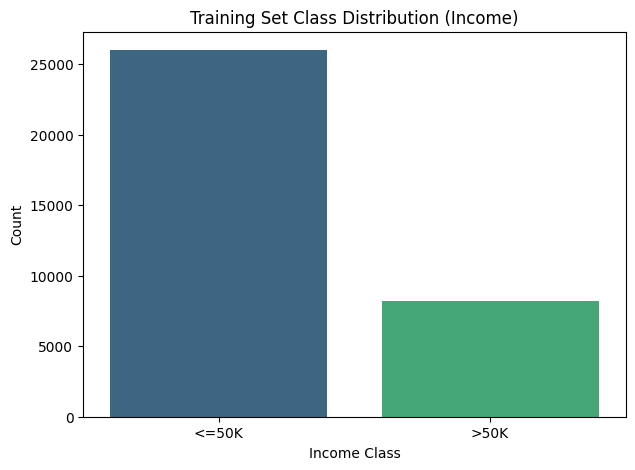

In [59]:
plt.figure(figsize=(7, 5))
y_train_counts = y_train.value_counts()
sns.barplot(x=y_train_counts.index, y=y_train_counts.values, palette='viridis')
plt.title('Training Set Class Distribution (Income)')
plt.xlabel('Income Class')
plt.ylabel('Count')

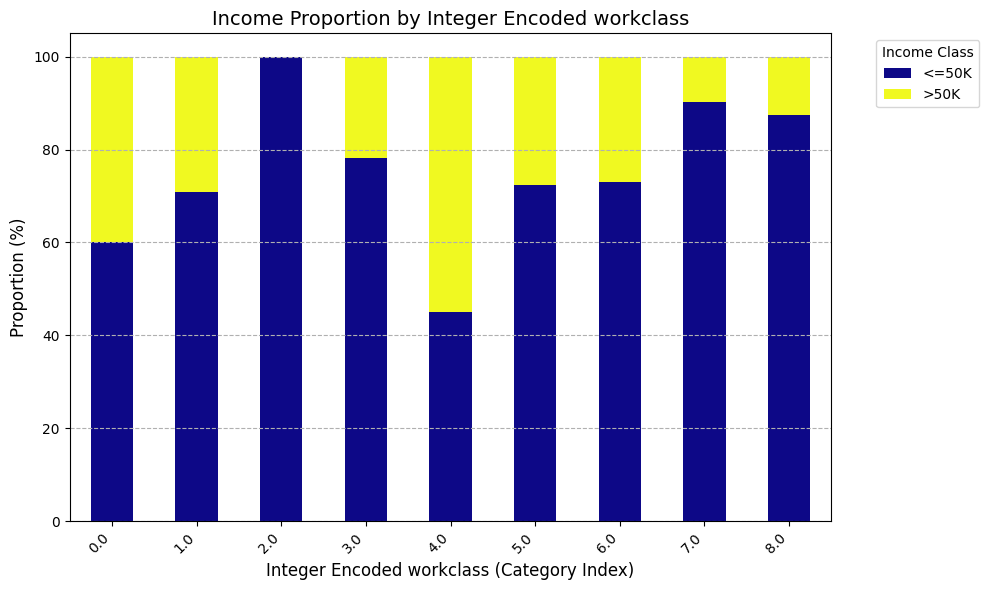

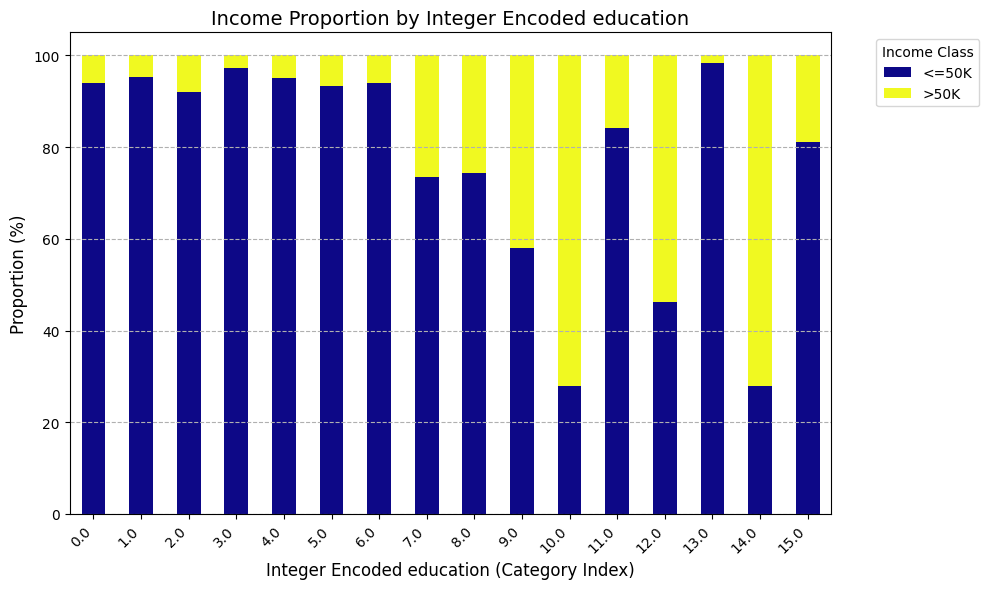

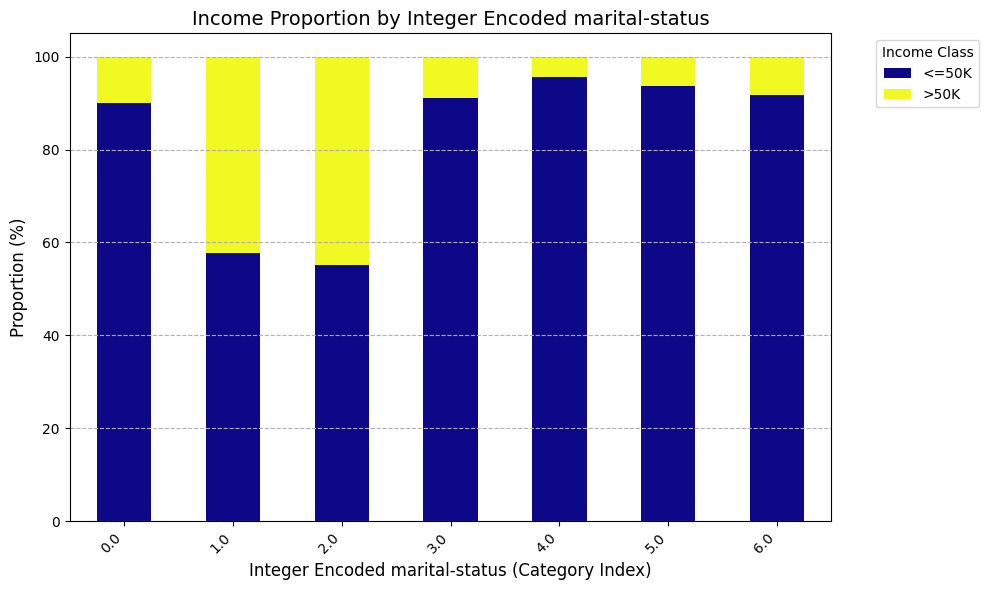

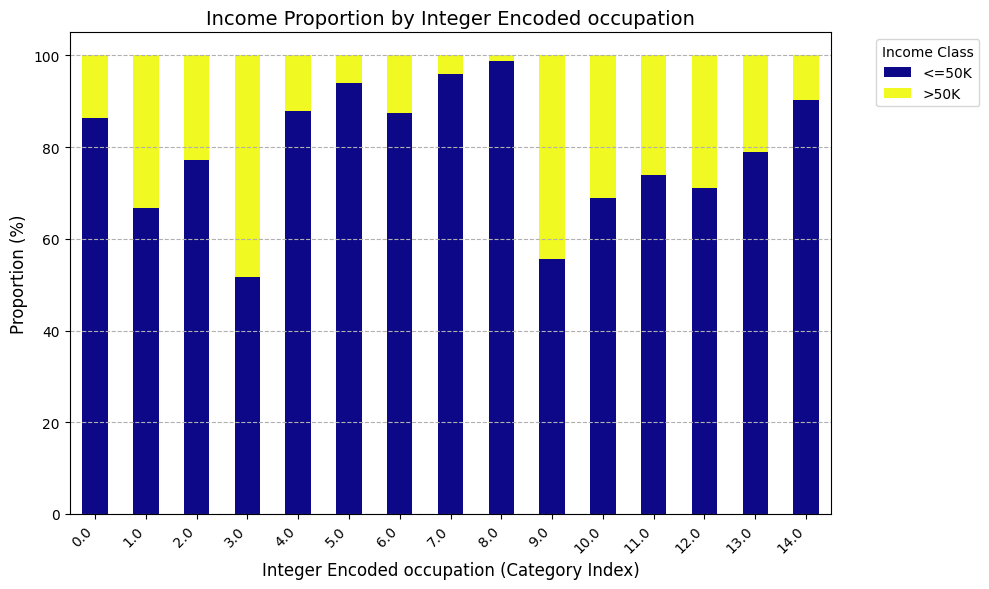

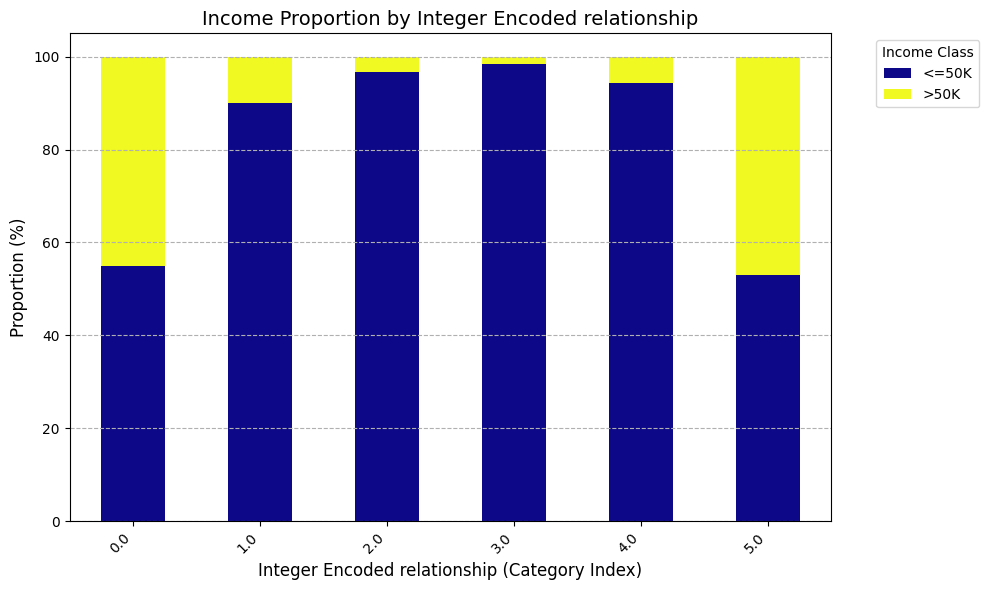

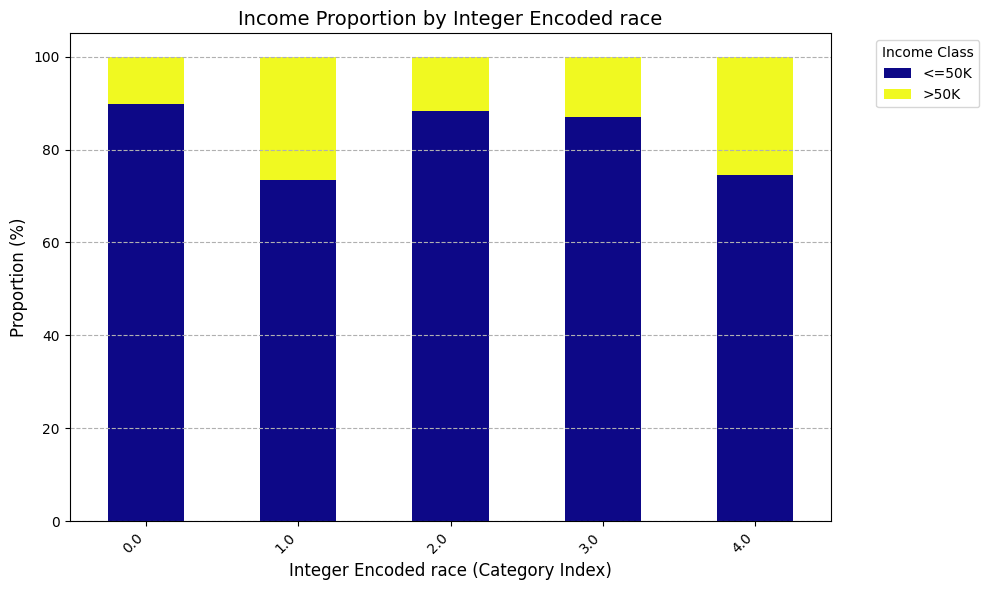

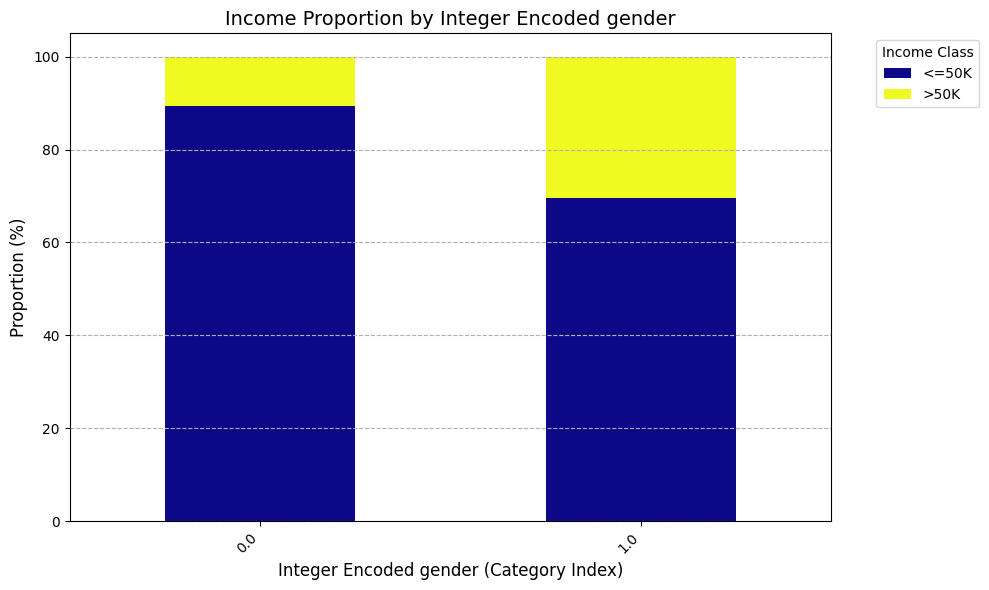

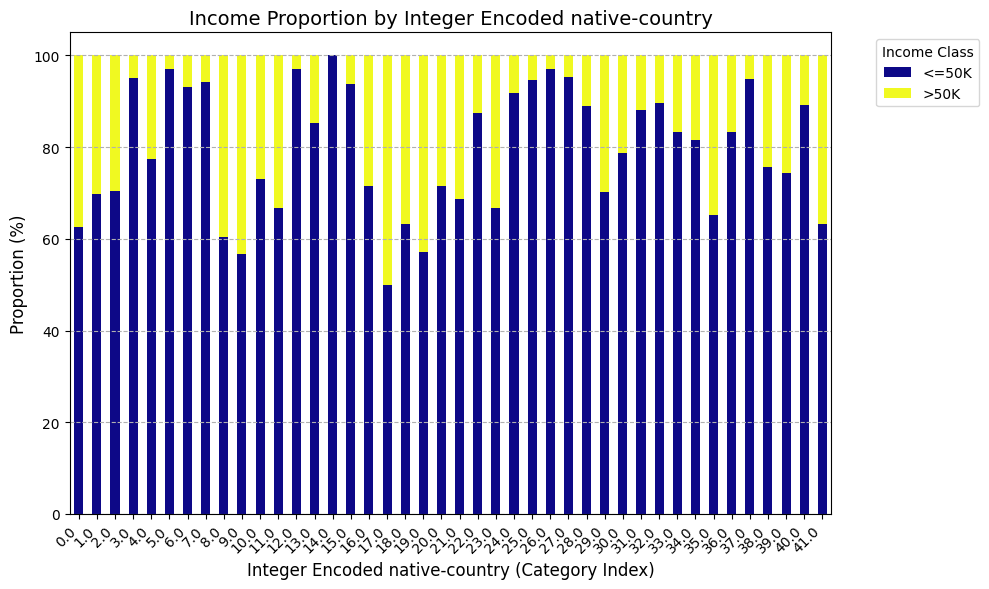

In [60]:
# Define the features to loop through
features_to_analyze = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'gender', 'native-country'
]

# 1. Combine training features and target into a single DataFrame for analysis
# This step is done once outside the loop for efficiency.
train_df = pd.concat([
    x_train.reset_index(drop=True),
    y_train.squeeze().reset_index(drop=True).rename('income')
], axis=1)

# 2. Loop through each categorical feature and display a plot
for feature in features_to_analyze:
    if feature not in train_df.columns:
        print(f"Skipping feature '{feature}' as it was not found in the training data columns.")
        continue

    # Cross-tabulation normalized by the feature (rows) to get proportions (percent)
    ct = pd.crosstab(train_df[feature], train_df['income'], normalize='index') * 100

    # Plotting the stacked bar chart
    plt.figure(figsize=(10, 6))

    # Use ct.plot to directly generate the stacked bar chart
    ct.plot(
        kind='bar',
        stacked=True,
        figsize=(10, 6),
        colormap='plasma',
        ax=plt.gca() # Plot onto the figure we just created
    )

    # Set plot titles and labels
    plt.title(f'Income Proportion by Integer Encoded {feature}', fontsize=14)
    plt.xlabel(f'Integer Encoded {feature} (Category Index)', fontsize=12)
    plt.ylabel('Proportion (%)', fontsize=12)
    plt.legend(title='Income Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()

    plt.show()

    # Close the figure to free up memory before the next loop iteration
    plt.close()

## naive bayes

class

(can create a fit method)

In [61]:
print(x_train.columns.to_numpy())

['workclass' 'education' 'marital-status' 'occupation' 'relationship'
 'race' 'gender' 'native-country']


In [82]:
class Naive:
  def __init__(self, x_train, y_train, alpha):
    self.x_train = x_train
    self.y_train = y_train
    self.alpha = alpha
    self.classes = y_train.unique()
    self.num_of_classes = len(y_train.unique())
    self.num_of_samples = x_train.shape[0]
    self.features = x_train.columns.to_numpy()
    self.priors = 0
    self.dict_of_likelihoods = {}
    self.positive_class_probs = []
    self.negative_class_probs = []
    self.unique_feature_counts = [
      len(np.unique(self.x_train.to_numpy()[:, i]))
      for i in range(self.x_train.shape[1])
      ]

  def set_alpha(self, alpha):
    self.alpha = alpha

  def set_feature_set(self, feature_set):
    self.x_train = feature_set
    self.features = self.x_train.columns.to_numpy()

  def get_priors(self): # P(k)
    list_of_priors = []
    prior_dtype = np.dtype([
        ('class_name', 'U20'), # String field for class name
        ('prior', 'f8')       # Float field for the probability
    ])
    for k in self.classes:
      prior = ((self.y_train.to_numpy() == k ).sum() + self.alpha) / (self.num_of_samples + self.alpha * self.num_of_classes)
      t = (k,prior)
      list_of_priors.append(t)
    priors = np.array(list_of_priors, dtype=prior_dtype)
    self.priors = priors
    # return self.priors

  def train(self):
    self.get_priors()
    self.dict_of_likelihoods = {}

    x_train_np = self.x_train.to_numpy()
    y_train_np = self.y_train.to_numpy()

    class_info = {}
    for k in self.classes:
        k_indices = (y_train_np == k)
        class_info[k] = {
            'indices': k_indices,
            'count': k_indices.sum()
        }

    for index, feature in enumerate(self.features): # loop over features
      unique_values_for_feature = np.unique(x_train_np[:, index])
      for value in unique_values_for_feature: # loop over possible values of feature
        for k in self.classes: # loop over possible classes
          info = class_info[k]
          k_indices = (y_train_np == k)
          # count_of_class_k = (k_indices).sum()
          count_of_class_k = info['count']
          count_of_x_in_class_k = ((x_train_np[:, index][info['indices']]) == value).sum()
          feature_likelihood = (count_of_x_in_class_k + self.alpha) / (count_of_class_k + self.alpha * self.unique_feature_counts[index])
          self.dict_of_likelihoods[(feature, value, k)] = feature_likelihood

  def predict(self, x_test, y_test):
    x_test_np = x_test.to_numpy()
    y_test_np = y_test.to_numpy()
    labels_list = y_test_np.tolist()
    predicted_list = []
    correct = 0
    total = len(y_test_np)
    for index, x_sample in enumerate(x_test_np):
      posteriors = [] # a new posteriors list for each sample
      for class_index, k in enumerate(self.classes):
        posterior = self.priors[class_index][1]
        for index, feature_x in enumerate(x_sample):
          posterior *= self.dict_of_likelihoods[(self.features[index], feature_x, k)]
        posteriors.append((posterior, k)) # list of tuples. each tuple has posterior and its corresponding class

    #___ this only works because there are only two classes
      if self.num_of_classes == 2:
        positive_class_post = posteriors[0][0]
        negative_class_post = posteriors[1][0]

        # getting probabilities
        evidence = 0
        for p in posteriors:
          evidence += p[0]
        positive_class_prob = positive_class_post / evidence
        negative_class_prob = negative_class_post / evidence

        self.positive_class_probs.append(positive_class_prob)
        self.negative_class_probs.append(negative_class_prob)
    #___

      # classification
      posteriors.sort(reverse=True)
      predicted_class = posteriors[0][1] # getting max posterior
      predicted_list.append(predicted_class)

    correct = (np.array(predicted_list) == y_test_np).sum()
    accuracy = correct / total
    return accuracy

  def plot_probability_distribution(self, y_test):
    plt.figure(figsize=(8, 5))
    # Use the positive class probabilities for the histogram
    sns.histplot(self.positive_class_probs, bins=20, kde=True)

    plt.title('Distribution of Predicted Positive Class Probabilities')
    plt.xlabel('P(Income > 50K)')
    plt.ylabel('Frequency / Density')
    plt.show()
    plt.figure(figsize=(8, 5))
    # Use the negative class probabilities for the histogram
    sns.histplot(self.negative_class_probs, bins=20, kde=True)

    plt.title('Distribution of Predicted negative Class Probabilities')
    plt.xlabel('P(Income <= 50K)')
    plt.ylabel('Frequency / Density')
    plt.show()

In [83]:
n = Naive(x_train, y_train, 0)
n.train()
print(f"Final accuracy: {n.predict(x_test, y_test)}")


Final accuracy: 0.7909103316500614


In [84]:
model = Naive(x_train, y_train, 0)

In [85]:
manual_alpha_accuracies = []
manual_alpha_final_accuracy = 0
manual_subests_acruacies = []
manual_subests_final_accuracy = 0

sk_alpha_accuracies = []
sk_alpha_final_accuracy = 0
sk_subests_acruacies = []
sk_subests_final_accuracy = 0

testing alpha values

In [86]:
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
best_alpha = alphas[0]
prev_accuracy = 0
for alpha in alphas:
  model.set_alpha(alpha)
  model.train()
  accuracy = model.predict(x_val, y_val)
  manual_alpha_accuracies.append(accuracy)
  if accuracy > prev_accuracy:
    prev_accuracy = accuracy
    best_alpha = alpha
  print(f"For alpha of value {alpha} - validation accuracy: {accuracy}")
  print("________________\n")
model.set_alpha(best_alpha)
print(f"Best alpha {best_alpha} - best validation accuracy: {prev_accuracy}")
model.train() # with best alpha
manual_alpha_final_accuracy = model.predict(x_test, y_test)
print(f"Final test accuracy: {manual_alpha_final_accuracy}")

For alpha of value 0.1 - validation accuracy: 0.7962052962052962
________________

For alpha of value 0.5 - validation accuracy: 0.7960687960687961
________________

For alpha of value 1.0 - validation accuracy: 0.795932295932296
________________

For alpha of value 2.0 - validation accuracy: 0.7957957957957958
________________

For alpha of value 5.0 - validation accuracy: 0.7955227955227955
________________

Best alpha 0.1 - best validation accuracy: 0.7962052962052962
Final test accuracy: 0.7909103316500614


testing diffrent subsets

In [87]:
SUBSET_A = [
    'education',
    'relationship',
    'marital-status'
]
SUBSET_B = [
    'workclass',
    'race',
    'gender'
]
SUBSET_C = [
    'education',
    'marital-status',
    'occupation',
    'native-country'
]

subsets = [SUBSET_A, SUBSET_B, SUBSET_C]

In [88]:
best_accuracy_subset = 0
best_subset = []
for index, subset in enumerate(subsets):
  model.set_feature_set(x_train[subset])
  model.train()
  accuracy = model.predict(x_val[subset], y_val)
  manual_subests_acruacies.append(accuracy)
  if accuracy > best_accuracy_subset:
    best_accuracy_subset = accuracy
    best_subset = subset
  print(f"For subset {index} - validation accuracy: {accuracy}")
  print("________________\n")
model.set_feature_set(x_train[best_subset])
print(f"Best subset {best_subset} \nBest validation accuracy: {best_accuracy_subset}")
model.train()
manual_subests_final_accuracy = model.predict(x_test[best_subset],y_test)
print(f"Final test accuracy: {manual_subests_final_accuracy}")


For subset 0 - validation accuracy: 0.7556647556647557
________________

For subset 1 - validation accuracy: 0.7646737646737647
________________

For subset 2 - validation accuracy: 0.8357903357903358
________________

Best subset ['education', 'marital-status', 'occupation', 'native-country'] 
Best validation accuracy: 0.8357903357903358
Final test accuracy: 0.8191620035485192


In [89]:
model.set_feature_set(x_train)
model.train()
model.predict(x_test, y_test)


np.float64(0.7909103316500614)

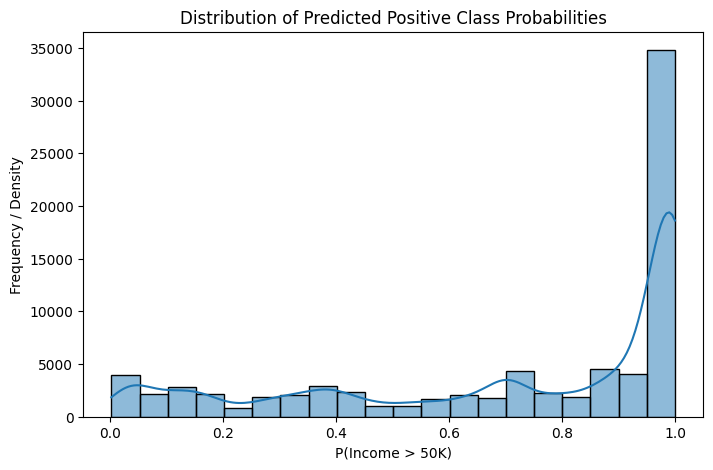

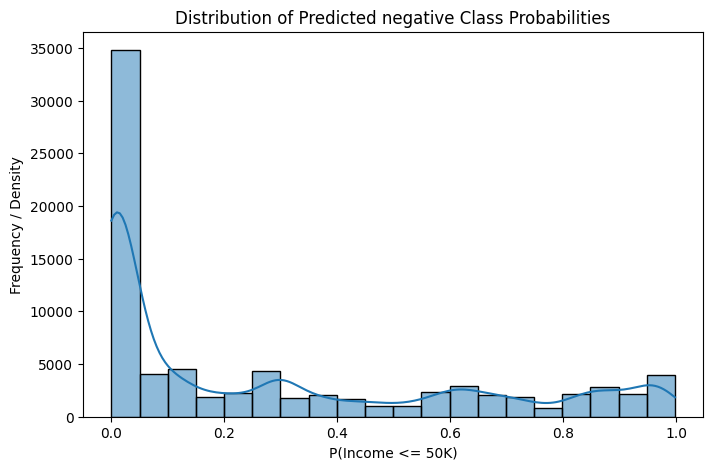

In [90]:
model.plot_probability_distribution(y_test)

sklearn naive

In [91]:
from sklearn.naive_bayes import MultinomialNB

In [92]:
sk_model = MultinomialNB()
sk_model.fit(x_train, y_train)
print(f"Prediction accuracy: {sk_model.score(x_test, y_test)}")


Prediction accuracy: 0.7435512488057868


manual tuning

In [93]:
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
best_alpha = alphas[0]
prev_accuracy = 0
sk_model = MultinomialNB(alpha=best_alpha)
for alpha in alphas:
  sk_model.fit(x_train, y_train)
  sk_model.set_params(alpha=alpha)
  accuracy = sk_model.score(x_val, y_val)
  sk_alpha_accuracies.append(accuracy)
  if accuracy > prev_accuracy:
    prev_accuracy = accuracy
    best_alpha = alpha
  print(f"For alpha of value {alpha} - validation accuracy: {accuracy}")
  print("________________\n")
sk_model.set_params(alpha=best_alpha)
sk_model.fit(x_train, y_train)
print(f"Best alpha {best_alpha} - best validation accuracy: {prev_accuracy}")
sk_alpha_final_accuracy = sk_model.score(x_test, y_test)
print(f"Final test accuracy: {sk_alpha_final_accuracy}")

For alpha of value 0.1 - validation accuracy: 0.7465192465192465
________________

For alpha of value 0.5 - validation accuracy: 0.7465192465192465
________________

For alpha of value 1.0 - validation accuracy: 0.7465192465192465
________________

For alpha of value 2.0 - validation accuracy: 0.7465192465192465
________________

For alpha of value 5.0 - validation accuracy: 0.7465192465192465
________________

Best alpha 0.1 - best validation accuracy: 0.7465192465192465
Final test accuracy: 0.7435512488057868


grid search tuning

In [94]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
nb_model = MultinomialNB()
grid_search = GridSearchCV(estimator=nb_model,
                           param_grid=param_grid,
                           cv=5, # Number of cross-validation folds
                           scoring='accuracy')

grid_search.fit(x_val, y_val)

print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best validation score (cross-validated): {grid_search.best_score_}")

print(f"Final test accuracy: {grid_search.score(x_test, y_test)}")

Best alpha: 0.1
Best validation score (cross-validated): 0.7582612015700589
Final test accuracy: 0.7562440289340794


In [95]:
best_accuracy_subset = 0
best_subset = []
for index, subset in enumerate(subsets):
  sk_model.fit(x_train[subset], y_train)
  accuracy = sk_model.score(x_val[subset], y_val)
  sk_subests_acruacies.append(accuracy)
  if accuracy > best_accuracy_subset:
    best_accuracy_subset = accuracy
    best_subset = subset
  print(f"For subset {index} - validation accuracy: {accuracy}")
  print("________________\n")
sk_model.fit(x_train[best_subset], y_train)
print(f"Best subset {best_subset} \nBest validation accuracy: {best_accuracy_subset}")
sk_subests_final_accuracy = sk_model.score(x_test[best_subset],y_test)
print(f"Final test accuracy: {sk_subests_final_accuracy}")


For subset 0 - validation accuracy: 0.7653562653562653
________________

For subset 1 - validation accuracy: 0.7607152607152607
________________

For subset 2 - validation accuracy: 0.7607152607152607
________________

Best subset ['education', 'relationship', 'marital-status'] 
Best validation accuracy: 0.7653562653562653
Final test accuracy: 0.7580182885219053


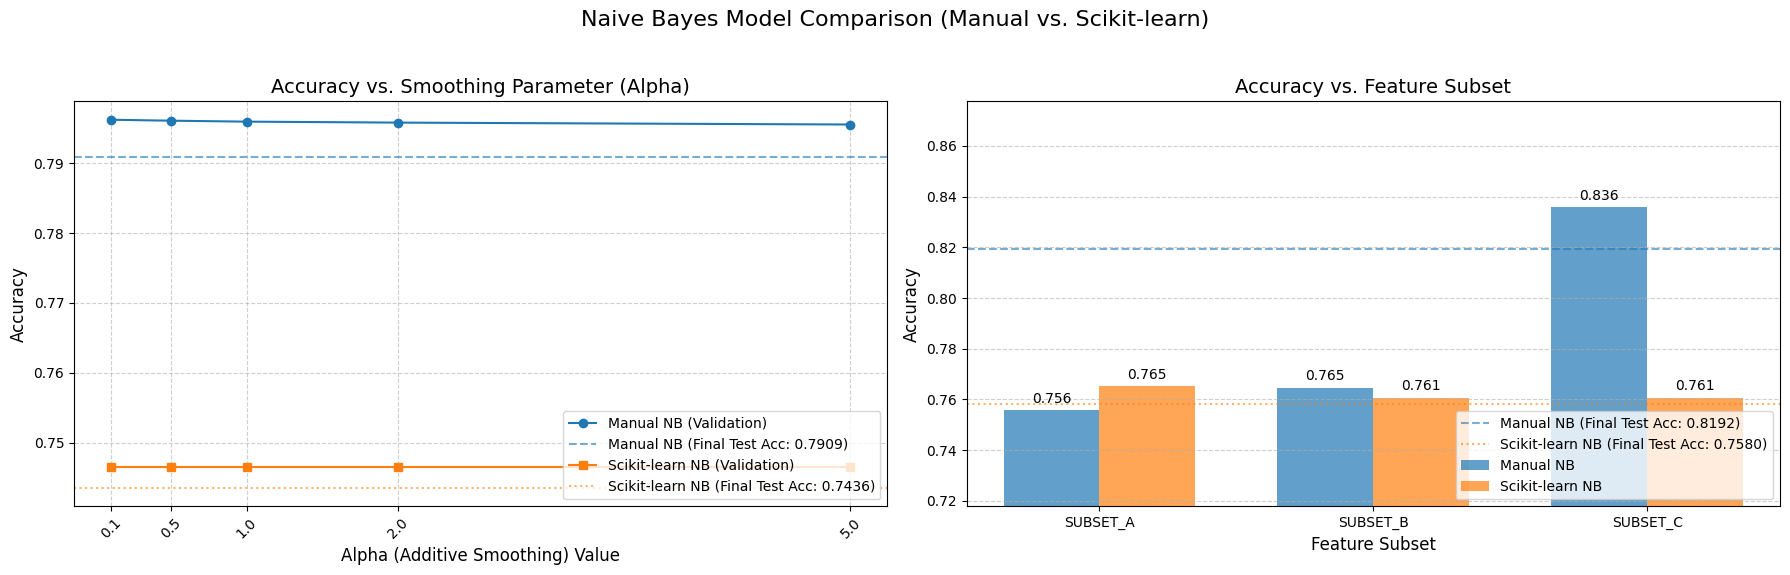

In [96]:
subset_labels = ['SUBSET_A', 'SUBSET_B', 'SUBSET_C']
x_subset = np.arange(len(subset_labels))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Naive Bayes Model Comparison (Manual vs. Scikit-learn)', fontsize=16)

# alpha Tuning Comparison
ax1.plot(alphas, manual_alpha_accuracies, marker='o', linestyle='-', color='tab:blue', label='Manual NB (Validation)')
ax1.axhline(manual_alpha_final_accuracy, color='tab:blue', linestyle='--', alpha=0.6, label=f'Manual NB (Final Test Acc: {manual_alpha_final_accuracy:.4f})')

ax1.plot(alphas, sk_alpha_accuracies, marker='s', linestyle='-', color='tab:orange', label='Scikit-learn NB (Validation)')
ax1.axhline(sk_alpha_final_accuracy, color='tab:orange', linestyle=':', alpha=0.6, label=f'Scikit-learn NB (Final Test Acc: {sk_alpha_final_accuracy:.4f})')

ax1.set_title('Accuracy vs. Smoothing Parameter (Alpha)', fontsize=14)
ax1.set_xlabel('Alpha (Additive Smoothing) Value', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xticks(alphas)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='lower right')
ax1.tick_params(axis='x', rotation=45)


# feature Subset Comparison
rects1 = ax2.bar(x_subset - width/2, manual_subests_acruacies, width, label='Manual NB', color='tab:blue', alpha=0.7)
ax2.bar_label(rects1, padding=3, fmt='%.3f')

rects2 = ax2.bar(x_subset + width/2, sk_subests_acruacies, width, label='Scikit-learn NB', color='tab:orange', alpha=0.7)
ax2.bar_label(rects2, padding=3, fmt='%.3f')

ax2.axhline(manual_subests_final_accuracy, color='tab:blue', linestyle='--', alpha=0.6, label=f'Manual NB (Final Test Acc: {manual_subests_final_accuracy:.4f})')
ax2.axhline(sk_subests_final_accuracy, color='tab:orange', linestyle=':', alpha=0.6, label=f'Scikit-learn NB (Final Test Acc: {sk_subests_final_accuracy:.4f})')


ax2.set_title('Accuracy vs. Feature Subset', fontsize=14)
ax2.set_xlabel('Feature Subset', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_xticks(x_subset, subset_labels)
ax2.set_ylim(min(min(manual_subests_acruacies), min(sk_subests_acruacies)) * 0.95,
             max(max(manual_subests_acruacies), max(sk_subests_acruacies)) * 1.05)
ax2.grid(axis='y', linestyle='--', alpha=0.6)
ax2.legend(loc='lower right')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()